In [7]:
from main import get_last_data_path
import pickle
from consts import GEMMA_2
from analysis import ComponentAnalyzer
import numpy as np
from typing import List, Tuple

data_dir = "data"

data_path = get_last_data_path(data_dir)
with open(data_path, "rb") as f:
    data = pickle.load(f)

In [8]:
gemma_2_data = data[GEMMA_2]
position = -1

print(gemma_2_data.keys())

dict_keys(['1161', '1200', '137', '3949', '4086', '4287', '5548', '6832', '695', '709', '7988', '8015', '1201', '1337', '14', '1555', '1752', '1818', '1838', '205', '2445', '2590', '269', '294', '3306', '384', '541', '881', '9154', '99'])


In [9]:
def sort_by_path_appearance(coefs: np.ndarray, feature_names: List[str]) -> List[Tuple[str, float]]:
    entry_order_indices = np.argmax(np.abs(coefs) > 0, axis=1)

    active_features_mask = np.any(np.abs(coefs) > 0, axis=1)
    active_feature_indices = np.where(active_features_mask)[0]

    # Map the entry order to the active features
    active_entry_order = entry_order_indices[active_feature_indices]

    # Sort the active features by their entry order
    final_sorted_indices = active_feature_indices[np.argsort(active_entry_order)]

    ordered_feature_names = [feature_names[i] for i in final_sorted_indices]

    return ordered_feature_names

In [10]:
import re

def component_to_layer_num(component_name: str) -> int:
    re_pattern = 'blocks\.(\d+)\.*'
    layer_num = re.search(re_pattern, component_name).group(1)
    layer_num = int(layer_num)
    return layer_num


In [15]:
from collections import defaultdict
r2_dict = defaultdict(list)
diff_in_r2_dict = defaultdict(list)

k = 4
num_layers = 21
mlp_top_k_frequencies = {"positive": [0 for _ in range(num_layers)], "negative": [0 for _ in range(num_layers)]}
attn_top_k_frequencies = {"positive": [0 for _ in range(num_layers)], "negative": [0 for _ in range(num_layers)]}
for steering_vector, per_vector_data in gemma_2_data.items():
    data_at_position = per_vector_data['all']

    negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
    negative_dots_train = negative_outputs_train[0]
    positive_dots_train = positive_outputs_train[0]
    negative_dots_test = negative_outputs_test[0]
    positive_dots_test = positive_outputs_test[0]


    analyzer = ComponentAnalyzer(
                model_name=GEMMA_2,
                steering_vector=steering_vector,
                data=per_vector_data,
                multicomponent=False,
                results_dir=None,
                quiet=True,
                save_details=False,
            )

    mlp_r2_positive, attn_r2_positive, coefs_mlp_positive, coefs_attn_positive, mlp_names, attn_names = analyzer.predictor.mlp_vs_attn(
        positive_dots_train,
        positive_dots_test
    )

    diff_in_r2_dict['diff'].append(attn_r2_positive - mlp_r2_positive)
    diff_in_r2_dict['set'].append('positive')

    r2_dict['component'].extend(['mlp', 'attn'])
    r2_dict['r2'].extend([mlp_r2_positive, attn_r2_positive])
    r2_dict['set'].extend(['positive', 'positive'])

    mlp_names = [component_to_layer_num(c) for c in mlp_names]
    attn_names = [component_to_layer_num(c) for c in attn_names]

    positive_mlp_features = sort_by_path_appearance(coefs_mlp_positive, mlp_names)
    positive_attn_features = sort_by_path_appearance(coefs_attn_positive, attn_names)

    for layer_index in range(k):
        mlp_top_k_frequencies["positive"][positive_mlp_features[layer_index]] += 1
        attn_top_k_frequencies["positive"][positive_attn_features[layer_index]] += 1

    mlp_r2_negative, attn_r2_negative, coefs_mlp_negative, coefs_attn_negative, ignore_mlp_names, ignore_attn_names = analyzer.predictor.mlp_vs_attn(
        negative_dots_train,
        negative_dots_test
    )

    diff_in_r2_dict['diff'].append(attn_r2_negative - mlp_r2_negative)
    diff_in_r2_dict['set'].append('negative')

    r2_dict['component'].extend(['mlp', 'attn'])
    r2_dict['r2'].extend([mlp_r2_negative, attn_r2_negative])
    r2_dict['set'].extend(['negative', 'negative'])

    negative_mlp_features = sort_by_path_appearance(coefs_mlp_negative, mlp_names)
    negative_attn_features = sort_by_path_appearance(coefs_attn_negative, attn_names)

    for layer_index in range(k):
        mlp_top_k_frequencies["negative"][negative_mlp_features[layer_index]] += 1
        attn_top_k_frequencies["negative"][negative_attn_features[layer_index]] += 1

    # print(f"\nResults for steering vector {steering_vector}:")
    # print(f"Positive MLP R2: {mlp_r2_positive}")
    # print(f"Positive ATTN R2: {attn_r2_positive}")
    # print(f"Negative MLP R2: {mlp_r2_negative}")
    # print(f"Negative ATTN R2: {attn_r2_negative}")


    # print("\nOrder of appearance in LARS path for:")
    # print(f"Positive MLP Features: {positive_mlp_features}")
    # print(f"Positive ATTN Features: {positive_attn_features}")
    # print(f"Negative MLP Features: {negative_mlp_features}")
    # print(f"Negative ATTN Features: {negative_attn_features}")
    


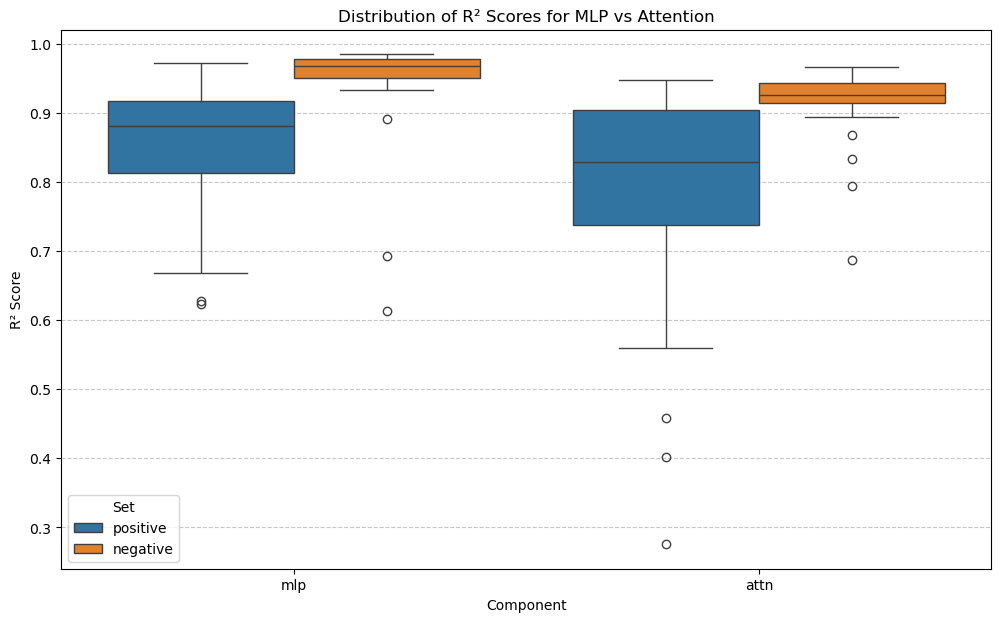

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

r2_df = pd.DataFrame(r2_dict)

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=r2_df,
    x='component',
    y='r2',
    hue='set',
)

plt.title('Distribution of R² Scores for MLP vs Attention')
plt.xlabel('Component')
plt.ylabel('R² Score')
plt.legend(title='Set')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

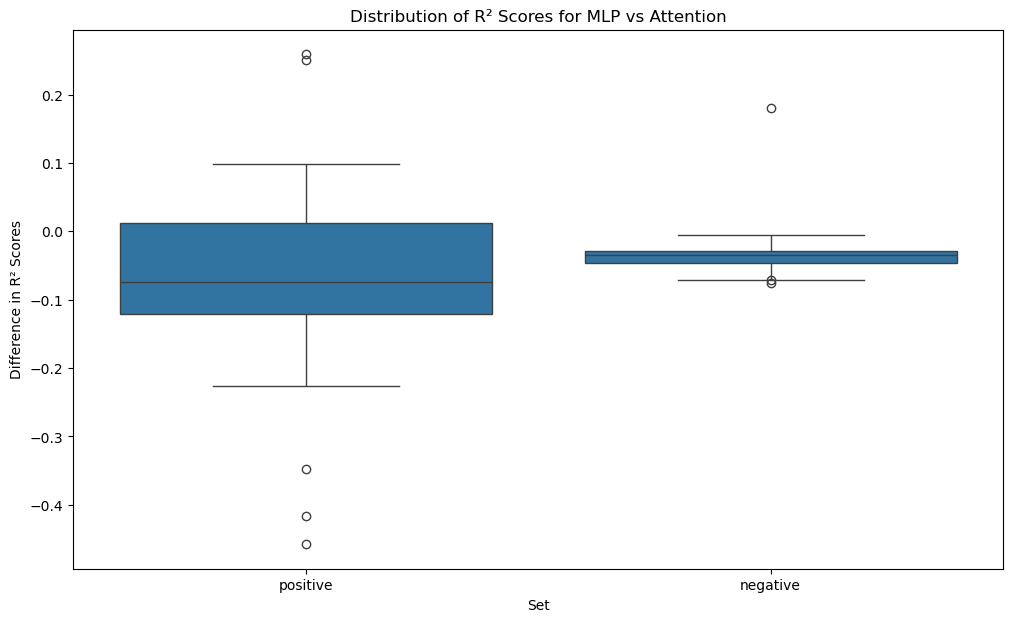

In [14]:
diff_in_r2_df = pd.DataFrame(diff_in_r2_dict)

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=diff_in_r2_df,
    x='set',
    y='diff',
)

plt.title('Distribution of R² Scores for MLP vs Attention')
plt.xlabel('Set')
plt.ylabel('Difference in R² Scores')
plt.show()

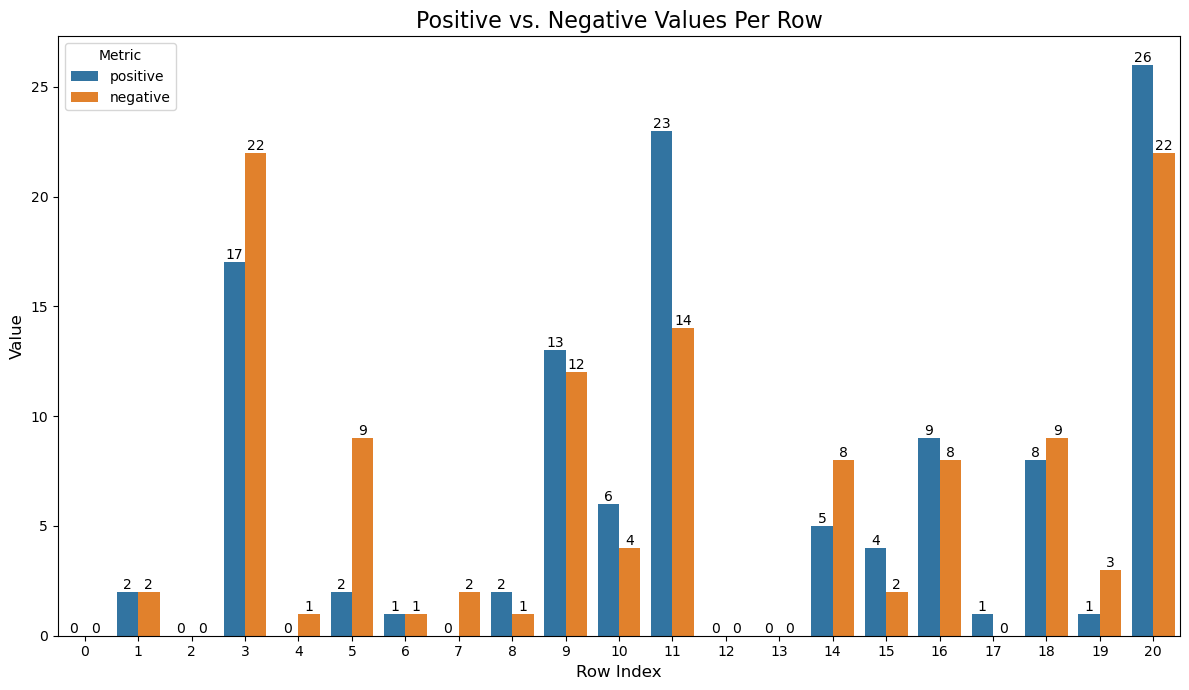

In [ ]:
mlp_top_k_frequencies_df = pd.DataFrame(mlp_top_k_frequencies)


df_long = mlp_top_k_frequencies_df.reset_index().melt(
    id_vars=['index'],
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='index', y='Value', hue='Metric', data=df_long)

plt.title(f'Number of times an MLP layer was in the top {k} features', fontsize=16)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for container in barplot.containers:
    barplot.bar_label(container)

plt.tight_layout()
plt.show()


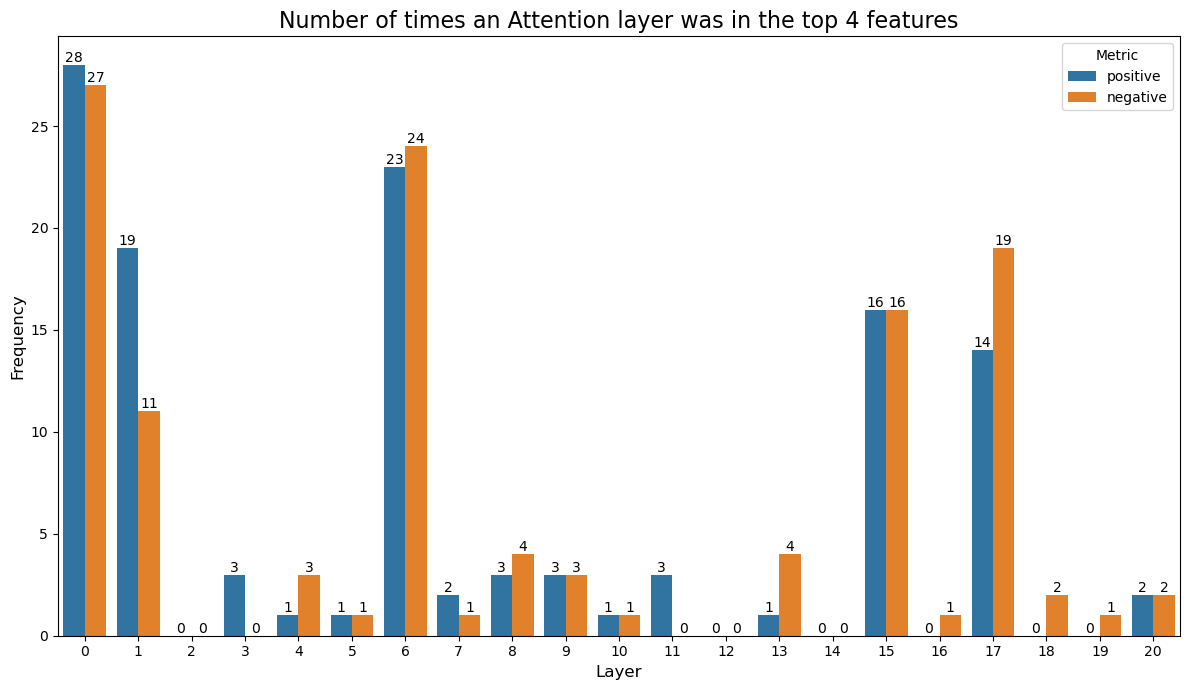

In [20]:
attn_top_k_frequencies_df = pd.DataFrame(attn_top_k_frequencies)


df_long = attn_top_k_frequencies_df.reset_index().melt(
    id_vars=['index'],
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='index', y='Value', hue='Metric', data=df_long)

plt.title(f'Number of times an Attention layer was in the top {k} features', fontsize=16)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for container in barplot.containers:
    barplot.bar_label(container)

plt.tight_layout()
plt.show()